# View images for representative classifiers
Author: Jess Ewald

Sam Chen ran classifiers for all of the 1% (batch 7 and 8). Here, we read in all of the results and view images for comparisons that we care about to make sure that the classifier results make sense. 

In [1]:
# Imports
import polars as pl
import numpy as np
from sh import aws
import os
from skimage.io import imread
from matplotlib import pyplot as plt
import matplotlib as mpl
from scipy import stats

from importlib import reload
import displayImages as di
reload(di)

import black
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
)

import warnings
warnings.filterwarnings("ignore")

DEBUG:jupyter_black:config: {'line_length': 79, 'target_versions': {<TargetVersion.PY310: 10>}}


<IPython.core.display.Javascript object>

In [2]:
sam_res_dir = "/dgx1nas1/storage/data/sam/codes/2021_09_01_VarChAMP/6.downstream_analysis_snakemake/outputs/results"
result_file = "profiles_tcdropped_filtered_var_mad_outlier_featselect/result.csv"
pm_dir = "/dgx1nas1/storage/data/jess/varchamp/platemaps"


In [3]:

batch7 = pl.read_csv(f"{sam_res_dir}/2024_01_23_Batch_7/{result_file}").with_columns(pl.lit("batch7").alias("Batch"))
batch8 = pl.read_csv(f"{sam_res_dir}/2024_02_06_Batch_8/{result_file}").with_columns(pl.lit("batch8").alias("Batch"))

res = pl.concat([batch7, batch8])

In [4]:
# concatenate all platemaps
pms = ["B7A1R1_P1.txt", "B7A1R1_P2.txt", "B7A1R1_P3.txt", "B7A1R1_P4.txt", "B7A2R1_P1.txt", "B8A1R2_P1.txt", "B8A1R2_P2.txt", "B8A1R2_P3.txt", "B8A1R2_P4.txt", "B8A2R2_P1.txt"]

pm_dfs = []
for pm in pms:
    try:
        temp = pl.read_csv(f"{pm_dir}/{pm}", separator="\t").select(['plate_map_name', 'well_position', 'control_type', 'gene_allele'])
        pm_dfs.append(temp)
    except Exception as e:
        print("Error reading {pm}: {e}")
    
pm_df = pl.concat(pm_dfs)

In [5]:
# calculate coefficient of variation for each comparison within each batch

cov = res.group_by(["Batch", "Group2"]).agg([
    pl.col("PR_AUC").std().alias("std_dev"),
    pl.col("PR_AUC").mean().alias("mean")
]).with_columns(
    (pl.col("std_dev") / pl.col("mean")).alias("cov")
)

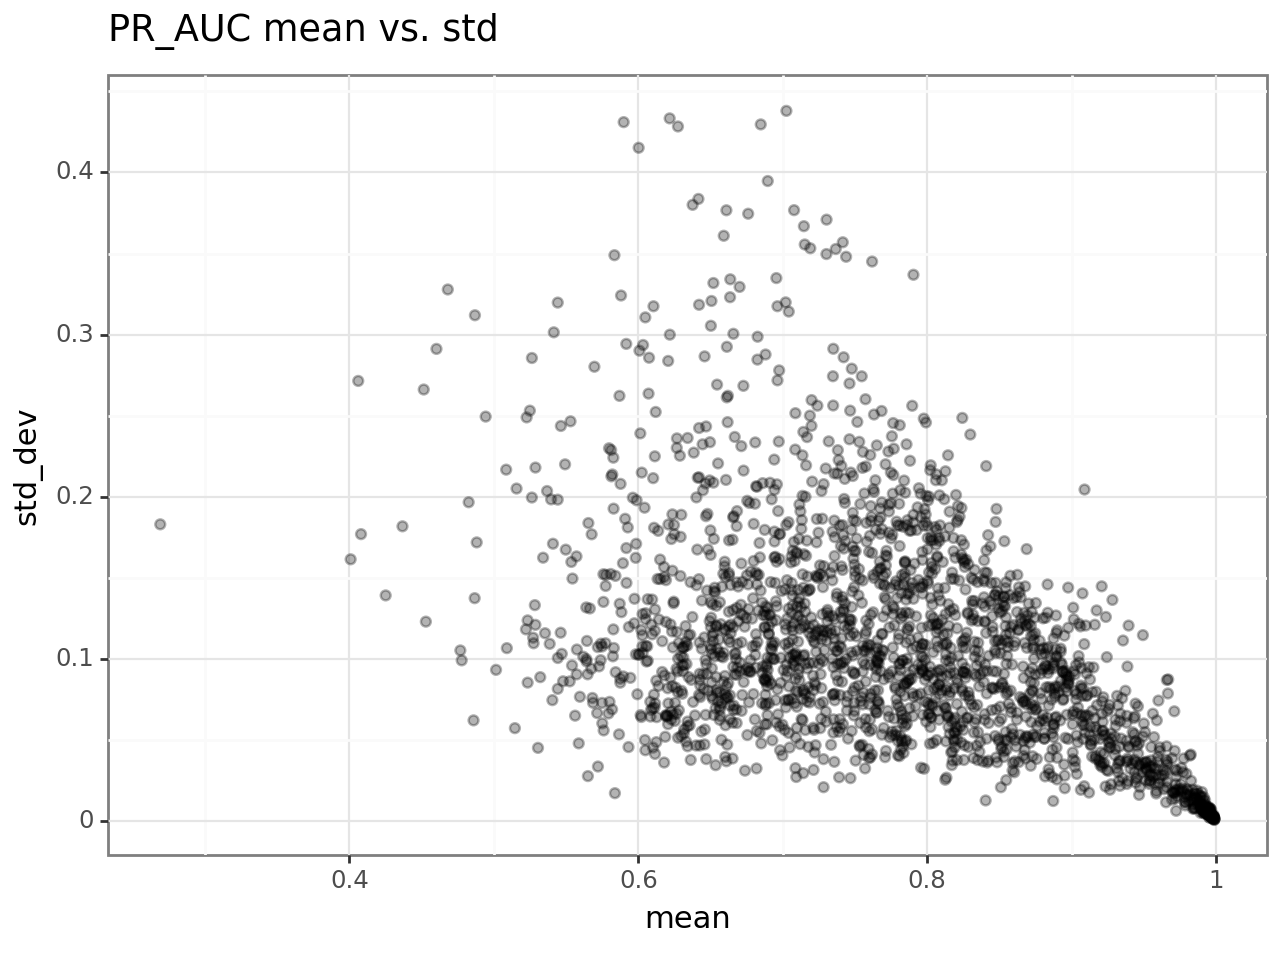

In [7]:
from plotnine import ggplot, aes, geom_point, theme_bw, ggtitle

plot1 = (ggplot(cov)
         + aes(x = "mean", y = "std_dev")
         + geom_point(alpha=0.3) + theme_bw() + ggtitle("PR_AUC mean vs. std"))
print(plot1)

In [6]:
cov_wtvar = res.filter(pl.col("Metadata_Control") == "false").group_by(["Batch", "Group2"]).agg([
    pl.col("PR_AUC").std().alias("std_dev"),
    pl.col("PR_AUC").mean().alias("mean")
]).with_columns(
    (pl.col("std_dev") / pl.col("mean")).alias("cov")
)

cov_ctrls = res.filter(pl.col("Metadata_Control") == "true").group_by(["Batch", "Group2"]).agg([
    pl.col("PR_AUC").std().alias("std_dev"),
    pl.col("PR_AUC").mean().alias("mean")
]).with_columns(
    (pl.col("std_dev") / pl.col("mean")).alias("cov")
)

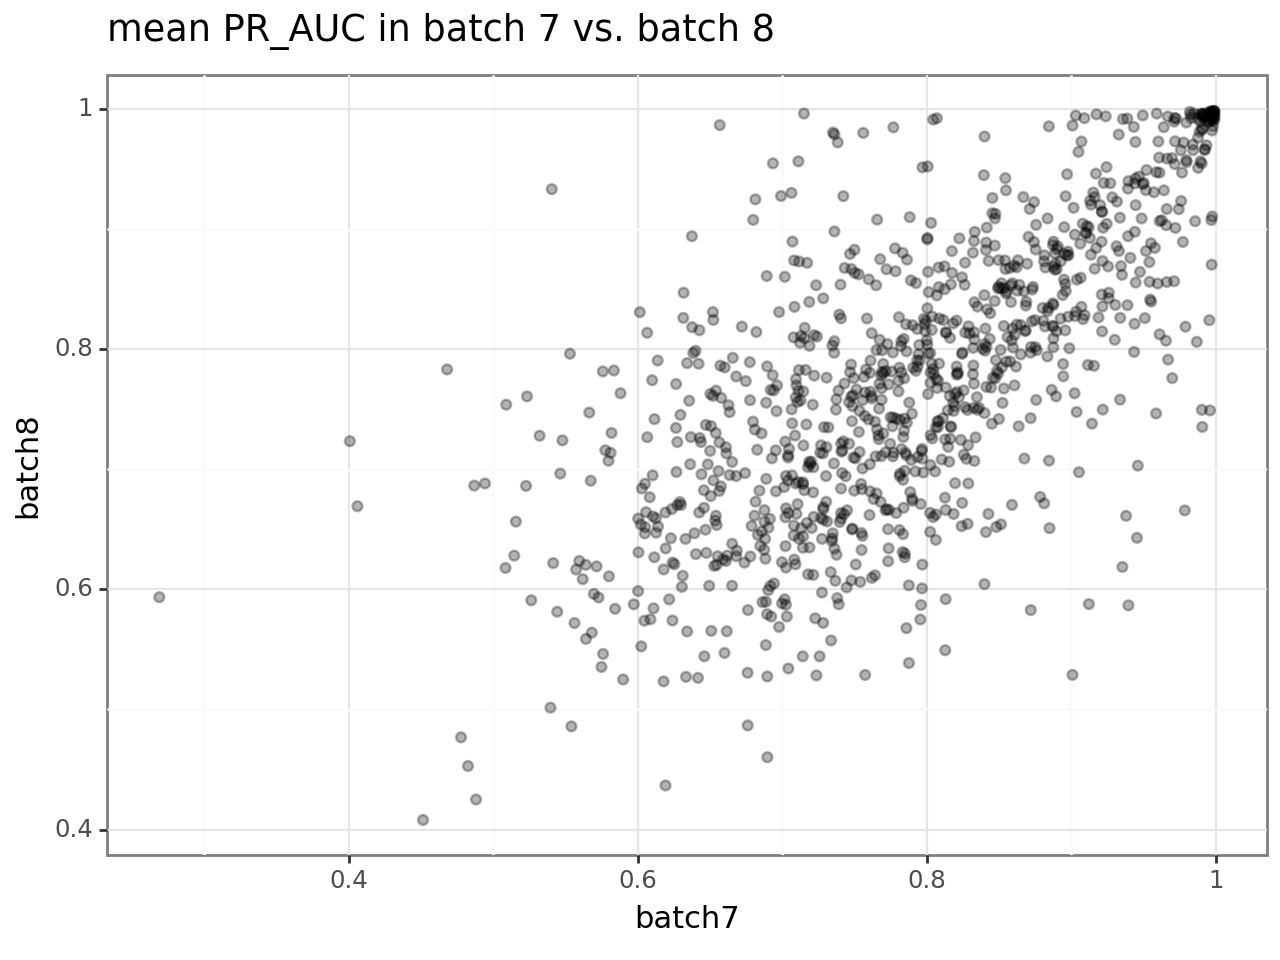

In [9]:
# Compare batch 7 and 8 results (mean PR AUC, wt-var pairs only)

cov_wtvar = cov_wtvar.pivot(index="Group2", columns="Batch", values="mean").drop_nulls()

plot1 = (ggplot(cov_wtvar)
         + aes(x = "batch7", y = "batch8")
         + geom_point(alpha=0.3) + theme_bw() + ggtitle("mean PR_AUC in batch 7 vs. batch 8"))
print(plot1)

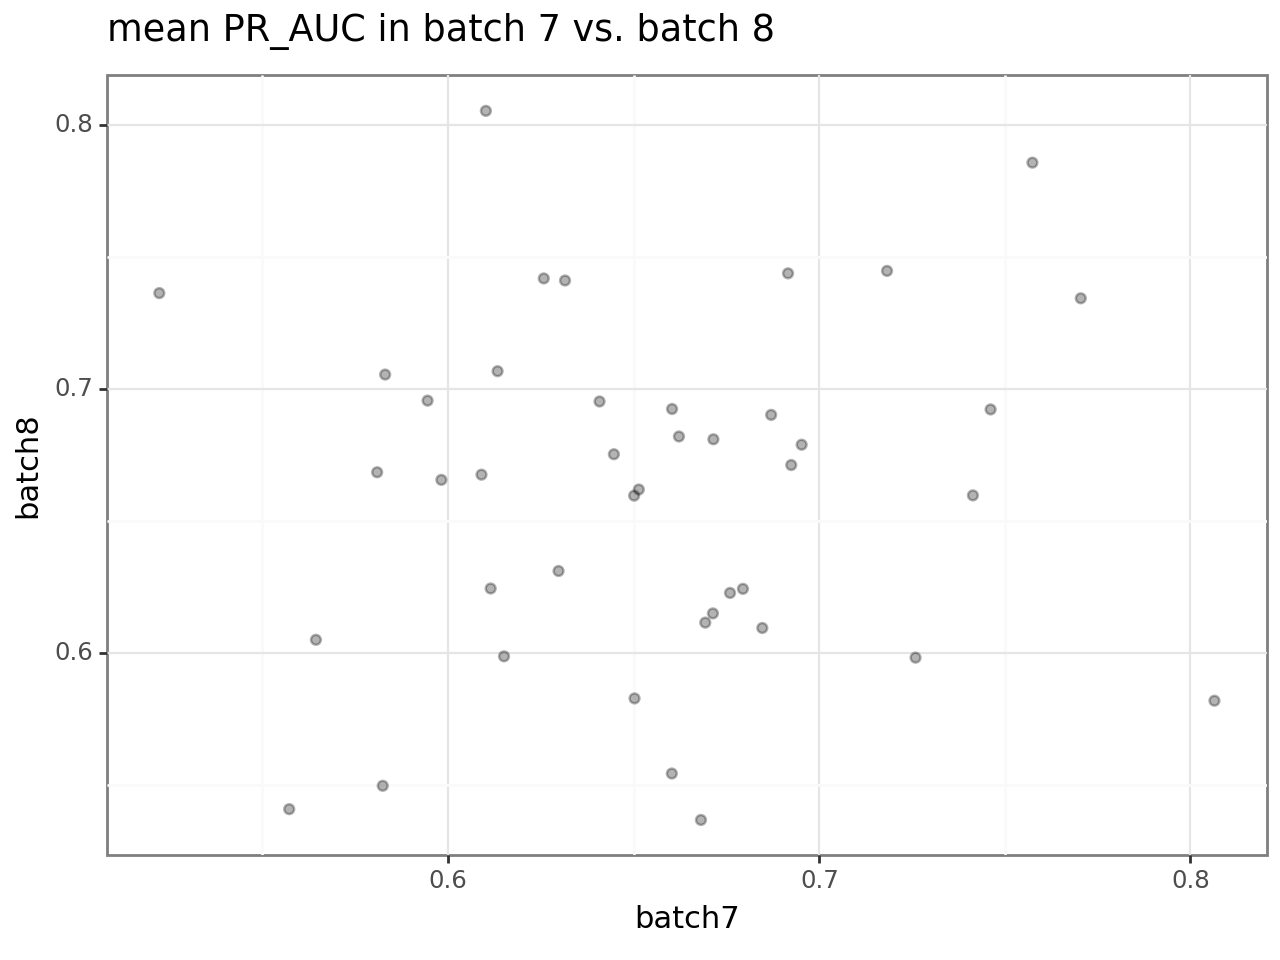

In [10]:
cov_ctrls = cov_ctrls.pivot(index="Group2", columns="Batch", values="mean").drop_nulls()

plot1 = (ggplot(cov_ctrls)
         + aes(x = "batch7", y = "batch8")
         + geom_point(alpha=0.3) + theme_bw() + ggtitle("mean PR_AUC in batch 7 vs. batch 8"))
print(plot1)

In [30]:
# calculate correlation between WT-VAR PR-AUC across batches
stats.pearsonr(
    cov_wtvar.select("batch7").to_series(),
    cov_wtvar.select("batch8").to_series()
)

PearsonRResult(statistic=0.6846731979085217, pvalue=7.333901044838542e-142)

In [31]:
# caculate correlation between CTRL-CTRL PR-AUC across batches
stats.pearsonr(
    cov_ctrls.select("batch7").to_series(),
    cov_ctrls.select("batch8").to_series()
)

PearsonRResult(statistic=0.07508634208953538, pvalue=0.6365001050786141)

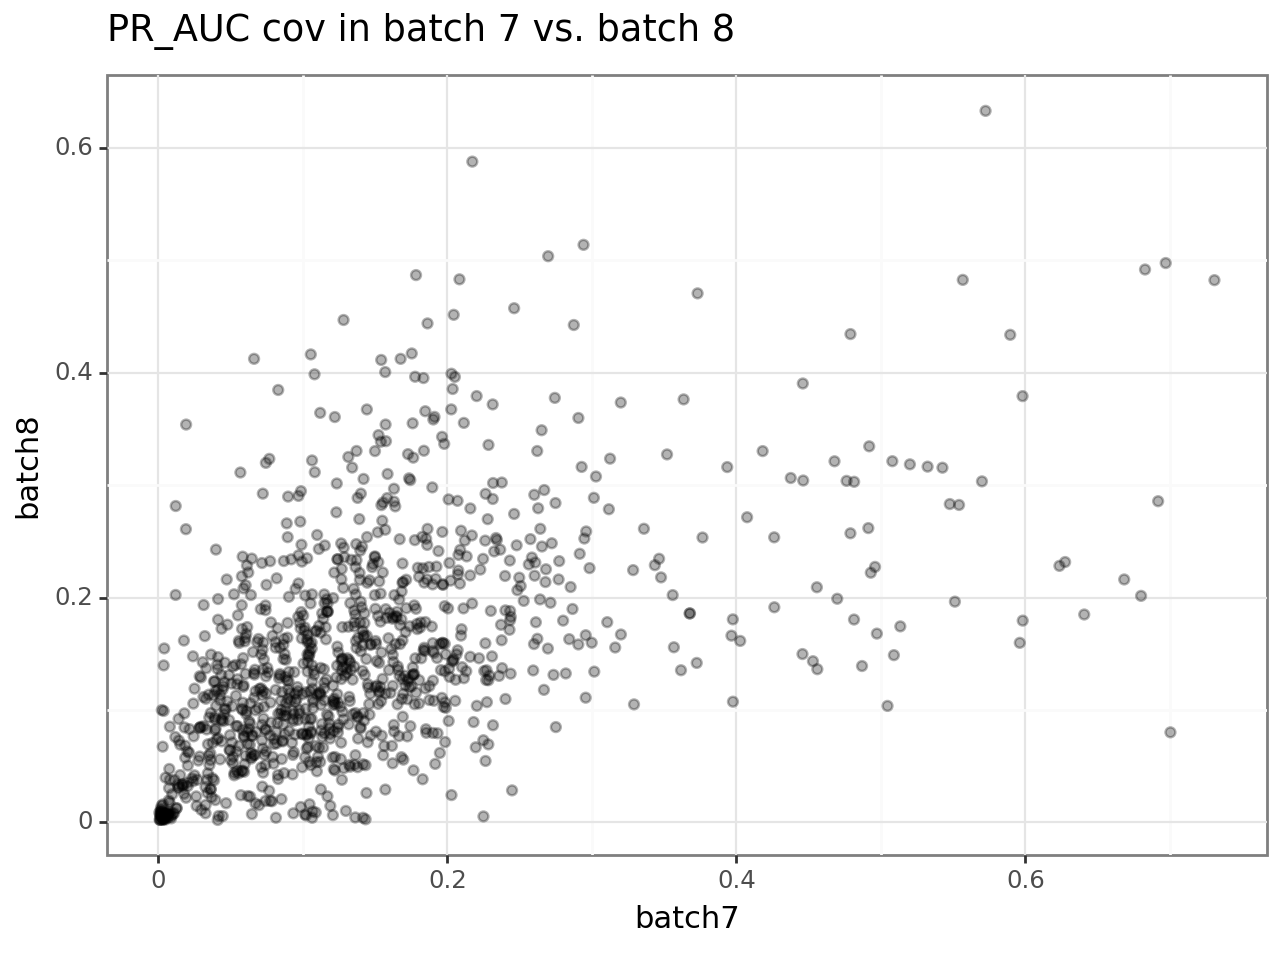

In [11]:
# Compare batch 7 and 8 results (PR AUC cov)

cov_batch = cov.pivot(index="Group2", columns="Batch", values="cov")

plot1 = (ggplot(cov_batch)
         + aes(x = "batch7", y = "batch8")
         + geom_point(alpha=0.3) + theme_bw() + ggtitle("PR_AUC cov in batch 7 vs. batch 8"))
print(plot1)

In [12]:
# evaluate which ones passed the NULL 0.95 threshold

prot_b7 = 0.774
prot_b8 = 0.841
nonprot_b7 = 0.993
nonprot_b8 = 0.883

res = res.with_columns(
    pl.when(
        (pl.col('Batch') == 'batch7') & (pl.col('Metadata_Protein'))
    ).then(
        pl.col('PR_AUC') > prot_b7
    ).when(
        (pl.col('Batch') == 'batch7') & ~pl.col('Metadata_Protein')
    ).then(
        pl.col('PR_AUC') > nonprot_b7
    ).when(
        (pl.col('Batch') == 'batch8') & (pl.col('Metadata_Protein'))
    ).then(
        pl.col('PR_AUC') > prot_b8
    ).when(
        (pl.col('Batch') == 'batch8') & ~pl.col('Metadata_Protein')
    ).then(
        pl.col('PR_AUC') > nonprot_b8
    ).otherwise(
        False  # Default case if none of the above conditions are met
    ).alias('Hit')
)


In [35]:
# Examine cases where we just barely pass the threshold

pass_prot_b7 = res.filter((pl.col("Metadata_Control") == "false") & 
                           (pl.col("Hit") == True) &
                           (pl.col("Metadata_Protein") == "true") &
                           (pl.col("Batch") == "batch7"))
pass_prot_b8 = res.filter((pl.col("Metadata_Control") == "false") & 
                           (pl.col("Hit") == True) &
                           (pl.col("Metadata_Protein") == "true") &
                           (pl.col("Batch") == "batch8"))

pass_nonprot_b7 = res.filter((pl.col("Metadata_Control") == "false") & 
                              (pl.col("Hit") == True) &
                              (pl.col("Metadata_Protein") == "false") &
                              (pl.col("Batch") == "batch7"))
pass_nonprot_b8 = res.filter((pl.col("Metadata_Control") == "false") & 
                              (pl.col("Hit") == True) &
                              (pl.col("Metadata_Protein") == "false") &
                              (pl.col("Batch") == "batch8"))

In [ ]:
# plot representative alleles that just barely passed
di.plotAllele(pm=pm_df, variant="AGXT_Gly41Arg", site="05", channel="GFP", replicate="T1", batch="B7A1R1", max_intensity=10000)
di.plotAllele(pm=pm_df, variant="COQ8A_Gly272Asp", site="05", channel="GFP", replicate="T4", batch="B7A1R1", max_intensity=2000)
di.plotAllele(pm=pm_df, variant="LITAF_Pro135Thr", site="05", channel="GFP", replicate="T3", batch="B7A1R1", max_intensity=3000)

Now check close calls for batch 8 (protein)

In [ ]:
di.plotAllele(pm=pm_df, variant="DES_Val56Leu", site="05", channel="GFP", replicate="T3", batch="B8A1R2", max_intensity=3000)
# note - more cells in bottom than you can see, GFP not showing in all

In [ ]:
di.plotAllele(pm=pm_df, variant="DCX_Ala71Ser", site="05", channel="GFP", replicate="T1", batch="B8A1R2", max_intensity=3000)

Check non-protein. 

In [ ]:
# Batch 7
di.plotAllele(pm=pm_df, variant="NR0B1_Arg267Pro", site="05", channel="AGP", replicate="T4", batch="B7A1R1", max_intensity=3000)
di.plotAllele(pm=pm_df, variant="CLDN19_Arg200Gln", site="05", channel="AGP", replicate="T3", batch="B7A1R1", max_intensity=3000)

In [ ]:
# Batch 8
di.plotAllele(pm=pm_df, variant="KRT6A_Gln166Pro", site="05", channel="AGP", replicate="T4", batch="B8A1R2", max_intensity=3000)
di.plotAllele(pm=pm_df, variant="FBP1_Gly164Ser", site="05", channel="AGP", replicate="T1", batch="B8A1R2", max_intensity=3000)

In [ ]:
di.plotImages("B8A2R2", "B8A2R2_P1", "05", "K13", "AGP", 2500, rep="T4")
di.plotImages("B8A2R2", "B8A2R2_P1", "05", "K14", "AGP", 2500, rep="T4")
di.plotImages("B8A2R2", "B8A2R2_P1", "05", "L13", "AGP", 2500, rep="T4")
di.plotImages("B8A2R2", "B8A2R2_P1", "05", "L14", "AGP", 2500, rep="T4")

In [ ]:
di.plotImages("B7A1R1", "B7A1R1_P1", "05", "K13", "AGP", 2500, rep="T4")
di.plotImages("B7A1R1", "B7A1R1_P1", "05", "K14", "AGP", 2500, rep="T4")
di.plotImages("B7A1R1", "B7A1R1_P1", "05", "L13", "AGP", 2500, rep="T4")
di.plotImages("B7A1R1", "B7A1R1_P1", "05", "L14", "AGP", 2500, rep="T4")

## Analyze cell count

In [7]:
# Get cell count per well
cc = pl.scan_parquet("/dgx1nas1/storage/data/sam/codes/2021_09_01_VarChAMP/6.downstream_analysis_snakemake/outputs/batch_profiles/2024_01_23_Batch_7/profiles.parquet")
cc = cc.select(['Metadata_well_position', 'Metadata_Plate', 'Metadata_gene_allele']).collect()
cc = cc.group_by(['Metadata_well_position', 'Metadata_Plate', 'Metadata_gene_allele']).agg(pl.count().alias("Cell_count"))
cc = cc.with_columns(pl.col("Metadata_Plate").str.slice(11, 22).alias("Metadata_Plate"))

cc8 = pl.scan_parquet("/dgx1nas1/storage/data/sam/codes/2021_09_01_VarChAMP/6.downstream_analysis_snakemake/outputs/batch_profiles/2024_02_06_Batch_8/profiles.parquet")
cc8 = cc8.select(['Metadata_well_position', 'Metadata_Plate', 'Metadata_gene_allele']).collect()
cc8 = cc8.group_by(['Metadata_well_position', 'Metadata_Plate', 'Metadata_gene_allele']).agg(pl.count().alias("Cell_count"))
cc8 = cc8.with_columns(pl.col("Metadata_Plate").str.slice(11, 22).alias("Metadata_Plate"))

cc = pl.concat([cc, cc8])

In [8]:
# annotate controls with well position info
res_ctrls = res.filter(pl.col("Metadata_Control") == "true").with_columns(
    pl.col("Metadata_Plate").str.slice(11, 22).alias("Metadata_Plate"),
    pl.col("Group2").str.slice(0,3).alias("Well1"),
    pl.col("Group2").str.slice(4,7).alias("Well2")
)


In [9]:
# annotate wt-vars with well position info
res_wtvar = res.filter(pl.col("Metadata_Control") == "false").rename(
    {"Group1": "gene_allele"}).with_columns(
        pl.col("Metadata_Plate").str.slice(11,22).alias("Metadata_Plate")
        )
res_wtvar = res_wtvar.with_columns(
    pl.col("Metadata_Plate").str.slice(0,9).alias("Metadata_Platemap")
)
 
# annotate Well1
res_wtvar = res_wtvar.join(pm_df.rename({"plate_map_name": "Metadata_Platemap"}).select(["Metadata_Platemap", "gene_allele", "well_position"]),
            on=["Metadata_Platemap", "gene_allele"]).rename({"well_position": "Well1"})

# annotate Well2
res_wtvar = res_wtvar.rename({"gene_allele": "Group1"}).with_columns(
    pl.col("Group2").str.split("_").list.slice(1,2).list.join("_").alias("gene_allele")
).join(pm_df.rename({"plate_map_name": "Metadata_Platemap"}).select(["Metadata_Platemap", "gene_allele", "well_position"]),
            on=["Metadata_Platemap", "gene_allele"]).rename({"well_position": "Well2"}).drop(["Metadata_Platemap", "gene_allele"])

In [10]:
# Add cell counts
res_cc = pl.concat([res_ctrls, res_wtvar]).join(
        cc.drop("Metadata_gene_allele").rename({"Metadata_well_position": "Well1", "Cell_count": "CC1"}), on=["Metadata_Plate", "Well1"]
    ).join(
        cc.drop("Metadata_gene_allele").rename({"Metadata_well_position": "Well2", "Cell_count": "CC2"}), on=["Metadata_Plate", "Well2"]
    )

In [11]:
# add more CC metrics
res_cc = res_cc.with_columns(
    (pl.col("CC1") + pl.col("CC2")).alias("Total_CC"),
    pl.min_horizontal("CC1", "CC2").alias("Minimum_CC"),
    (pl.max_horizontal("CC1", "CC2")/pl.min_horizontal("CC1", "CC2")).alias("FC_CC"),
    (pl.col("CC1")/(pl.col("CC1") + pl.col("CC2"))).alias("prob_pos")
)

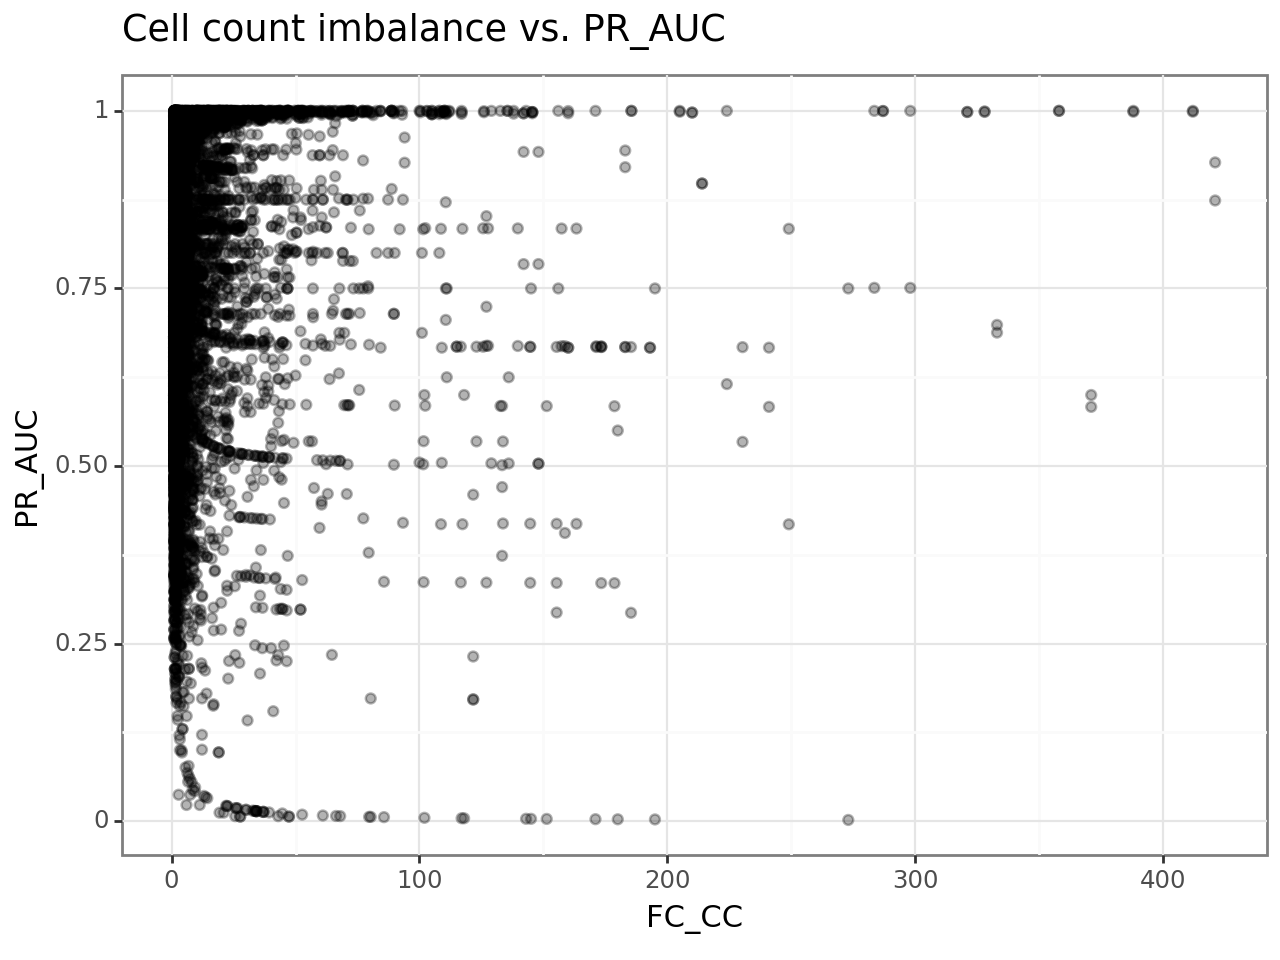

In [18]:
# PR_AUC vs. CC imbalance
plot1 = (ggplot(res_cc)
         + aes(x = "FC_CC", y = "PR_AUC")
         + geom_point(alpha=0.3) + theme_bw() + ggtitle("Cell count imbalance vs. PR_AUC"))
print(plot1)

## Examine relationships in controls

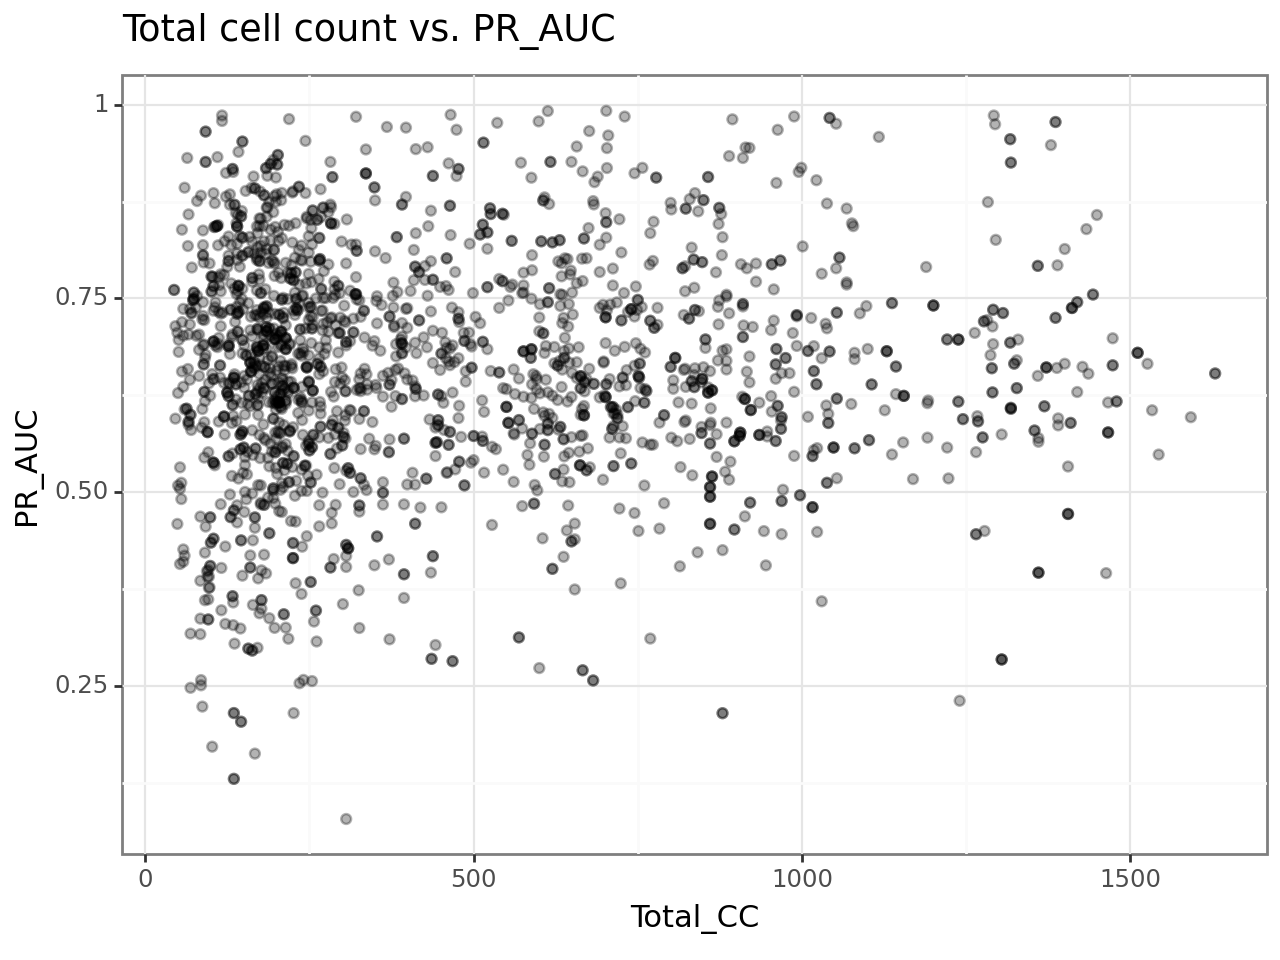

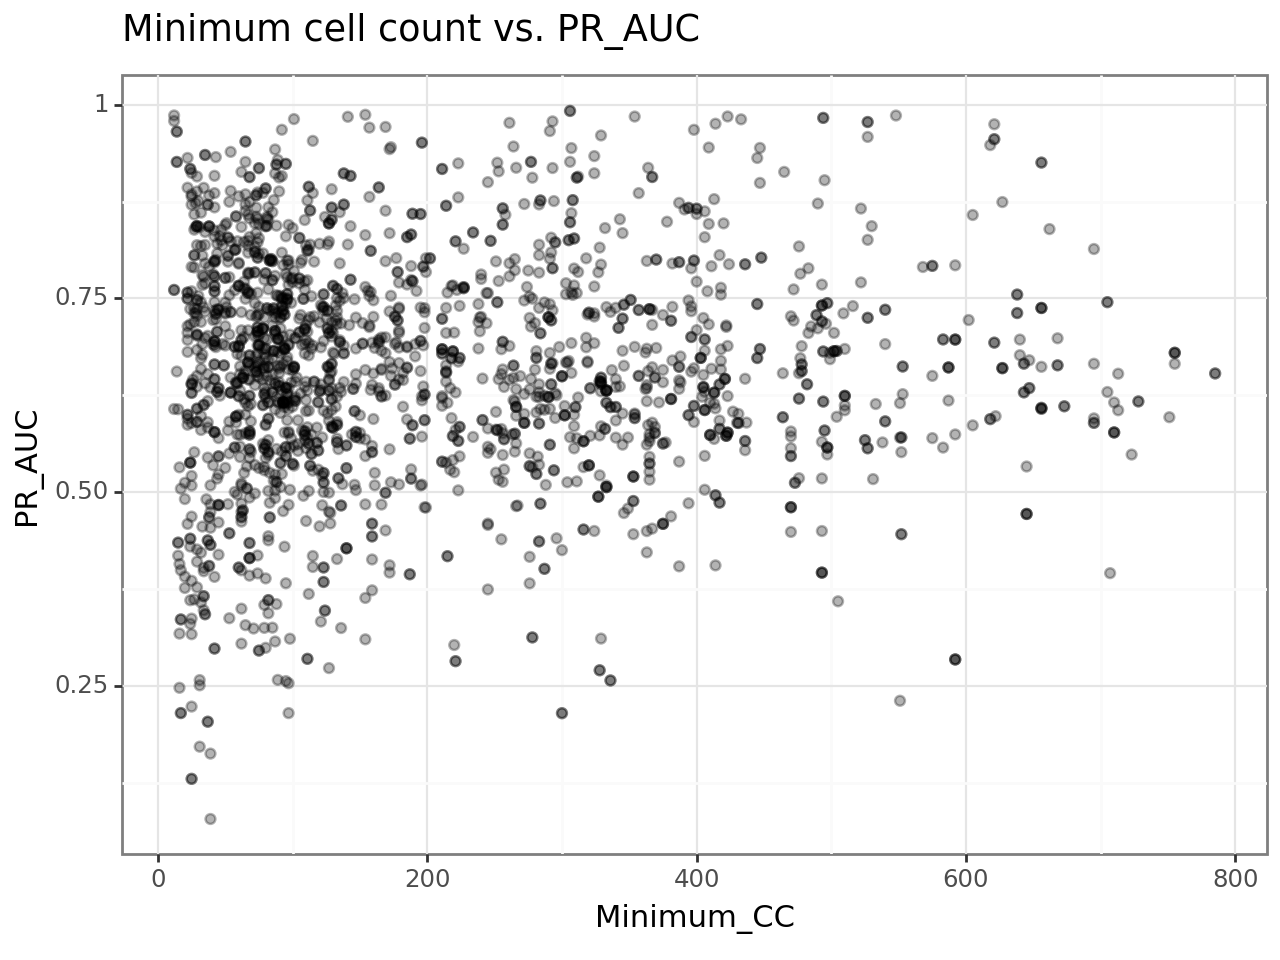

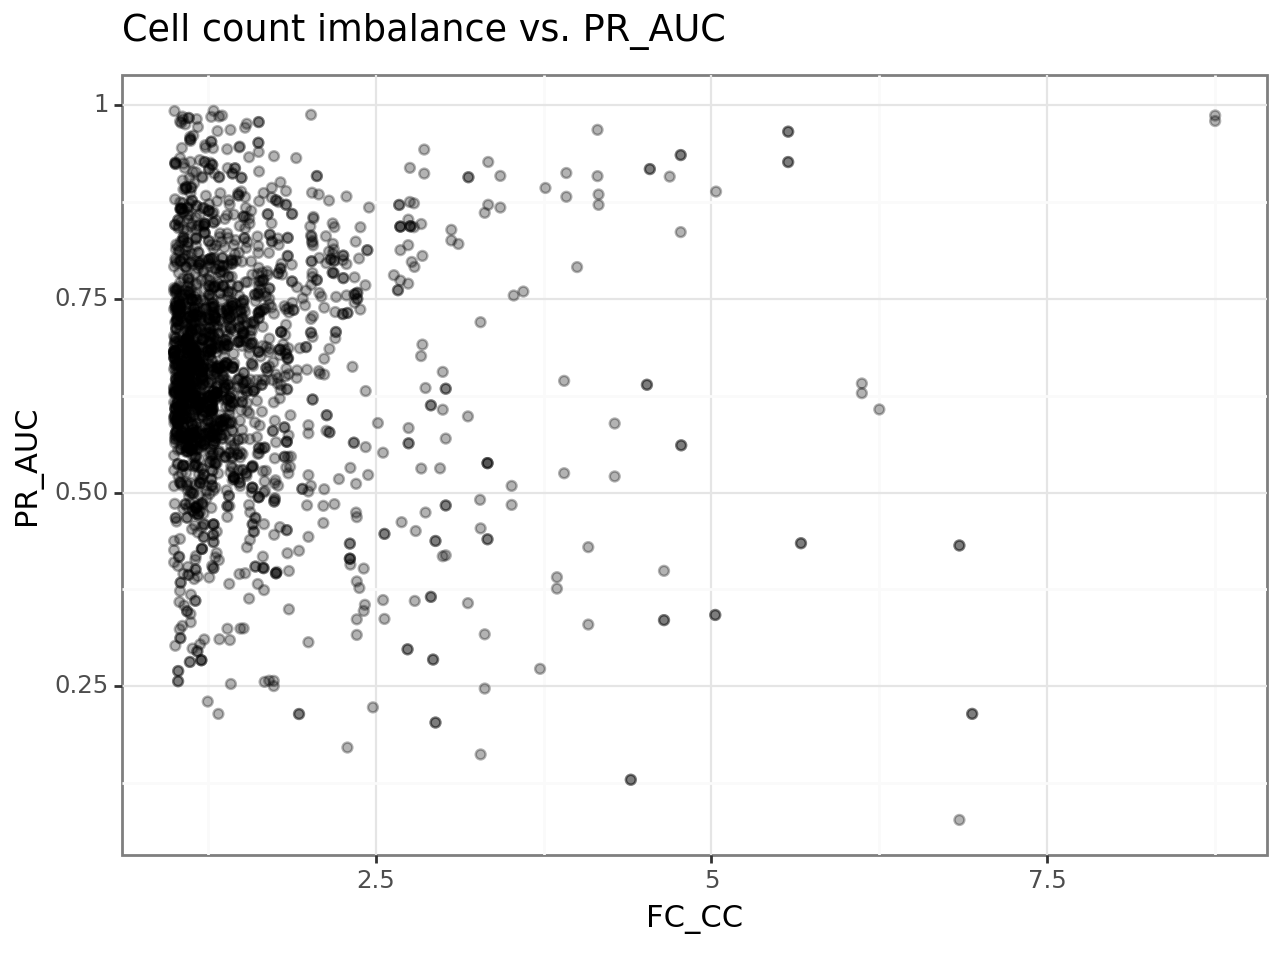

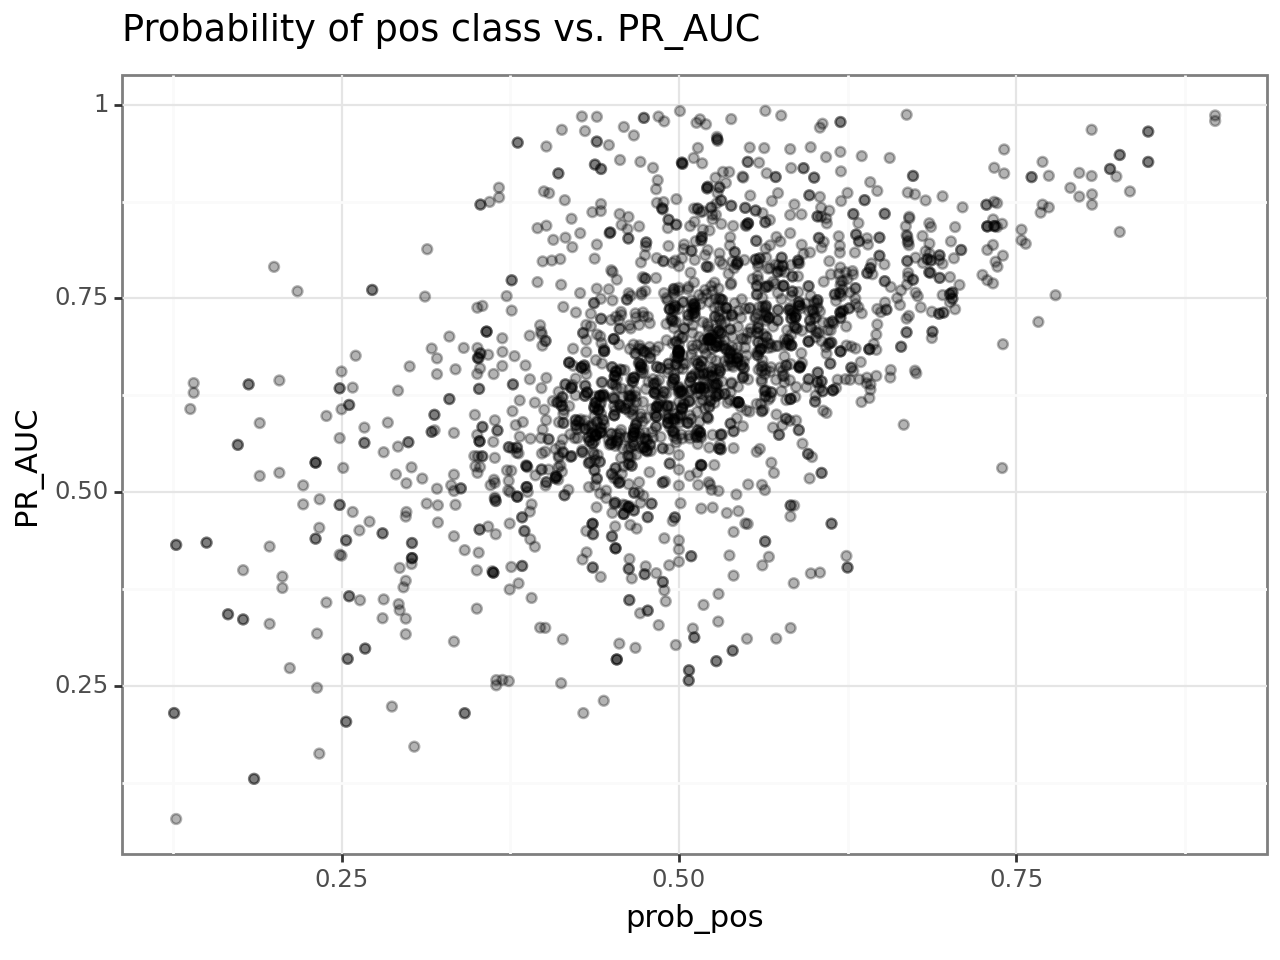

In [15]:
res_cc_filt = res_cc.filter((pl.col("Metadata_Control") == "true") &
                              (pl.col("Minimum_CC") >= 10))
from plotnine import *

# look at just WT-VAR, after filtering to remove those with fewer than 10 minimum cells
plot1 = (ggplot(res_cc_filt)
         + aes(x = "Total_CC", y = "PR_AUC")
         + geom_point(alpha=0.3) + theme_bw() + ggtitle("Total cell count vs. PR_AUC"))
print(plot1)

plot2 = (ggplot(res_cc_filt)
         + aes(x = "Minimum_CC", y = "PR_AUC")
         + geom_point(alpha=0.3) + theme_bw() + ggtitle("Minimum cell count vs. PR_AUC"))
print(plot2)

plot3 = (ggplot(res_cc_filt)
         + aes(x = "FC_CC", y = "PR_AUC")
         + geom_point(alpha=0.3) + theme_bw() + ggtitle("Cell count imbalance vs. PR_AUC"))
print(plot3)

plot4 = (ggplot(res_cc_filt)
         + aes(x = "prob_pos", y = "PR_AUC")
         + geom_point(alpha=0.3) + theme_bw() + ggtitle("Probability of pos class vs. PR_AUC"))
print(plot4)

In [16]:
print("Total cell count")
print(stats.pearsonr(
    res_cc_filt.drop_nulls().select("Total_CC").to_series(),
    res_cc_filt.drop_nulls().select("PR_AUC").to_series()
))
print(stats.spearmanr(
    res_cc_filt.drop_nulls().select("Total_CC").to_series(),
    res_cc_filt.drop_nulls().select("PR_AUC").to_series()
))

print("Minimum cell count")
print(stats.pearsonr(
    res_cc_filt.drop_nulls().select("Minimum_CC").to_series(),
    res_cc_filt.drop_nulls().select("PR_AUC").to_series()
))
print(stats.spearmanr(
    res_cc_filt.drop_nulls().select("Minimum_CC").to_series(),
    res_cc_filt.drop_nulls().select("PR_AUC").to_series()
))

print("FC cell count")
print(stats.pearsonr(
    res_cc_filt.drop_nulls().select("FC_CC").to_series(),
    res_cc_filt.drop_nulls().select("PR_AUC").to_series()
))
print(stats.spearmanr(
    res_cc_filt.drop_nulls().select("FC_CC").to_series(),
    res_cc_filt.drop_nulls().select("PR_AUC").to_series()
))

print("Probability of positive class}")
print(stats.pearsonr(
    res_cc_filt.drop_nulls().select("prob_pos").to_series(),
    res_cc_filt.drop_nulls().select("PR_AUC").to_series()
))
print(stats.spearmanr(
    res_cc_filt.drop_nulls().select("prob_pos").to_series(),
    res_cc_filt.drop_nulls().select("PR_AUC").to_series()
))

Total cell count
PearsonRResult(statistic=0.019379561567614688, pvalue=0.3892378756885292)
SignificanceResult(statistic=-0.010460520109946598, pvalue=0.6421378322570099)
Minimum cell count
PearsonRResult(statistic=0.021474956882099286, pvalue=0.3400251757922113)
SignificanceResult(statistic=-0.013717110491219842, pvalue=0.5422600902315025)
FC cell count
PearsonRResult(statistic=-0.04843270691819334, pvalue=0.03133105849860408)
SignificanceResult(statistic=0.030259274356657463, pvalue=0.17877102043890591)
Probability of positive class}
PearsonRResult(statistic=0.5406494680431814, pvalue=2.0931597081069266e-150)
SignificanceResult(statistic=0.5406559382615268, pvalue=2.0728103021379815e-150)


## Examine relationships in WT-VARs

In [17]:
res_cc_filt = res_cc.filter((pl.col("Metadata_Control") == "false") &
                              (pl.col("Minimum_CC") >= 10) &
                              (pl.col("FC_CC") < 10))

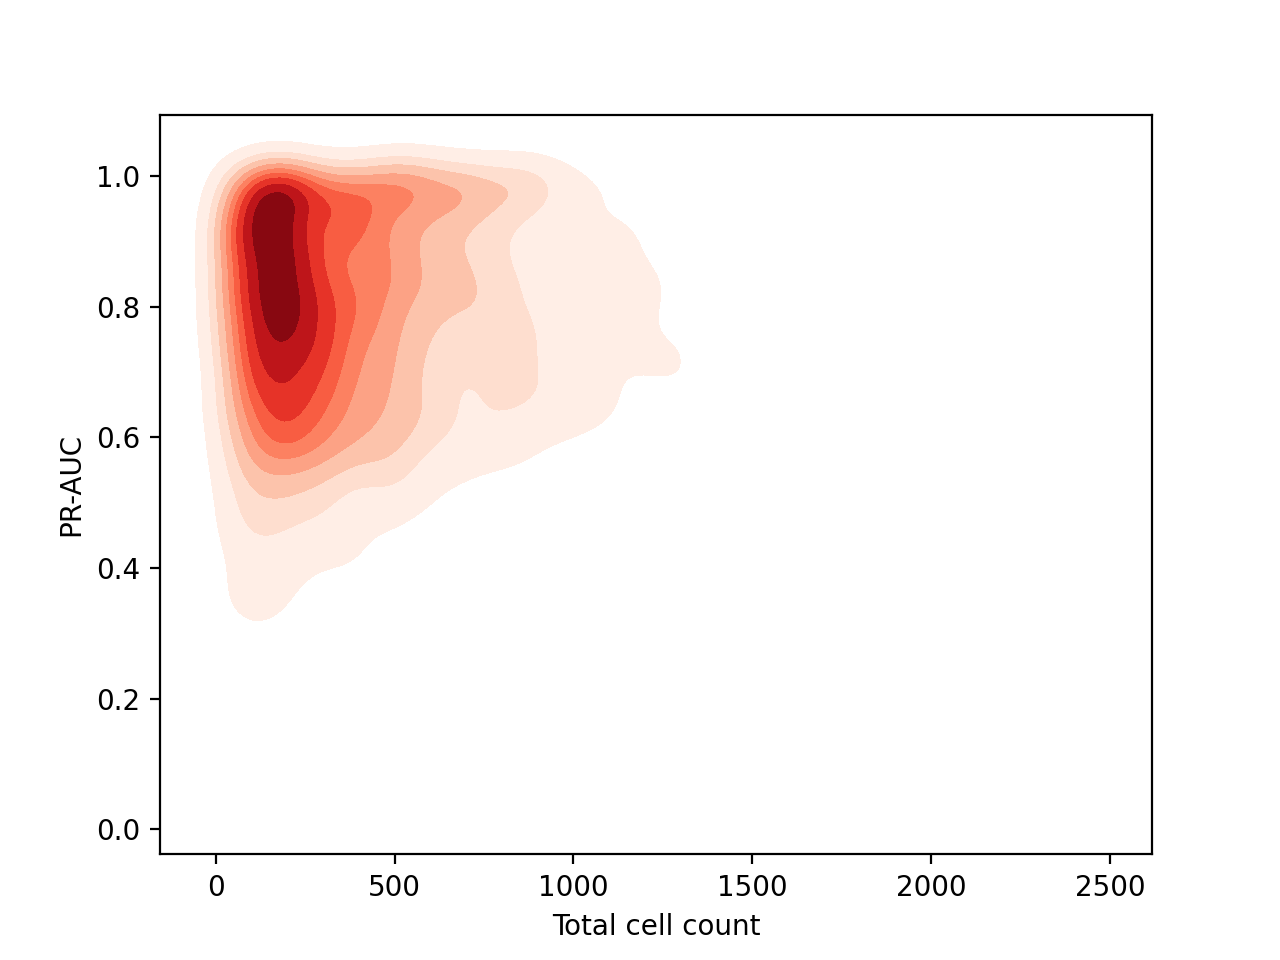

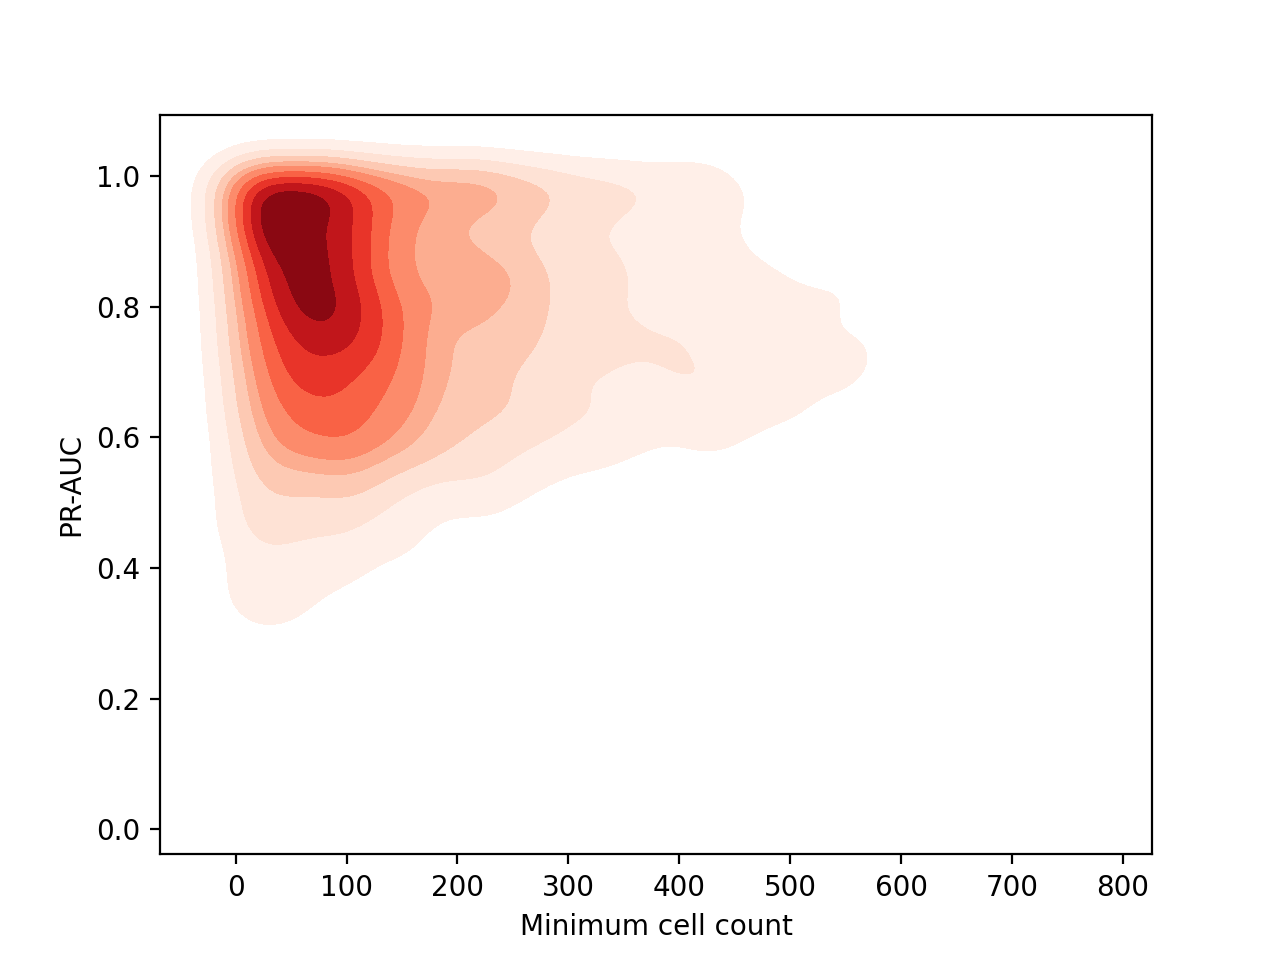

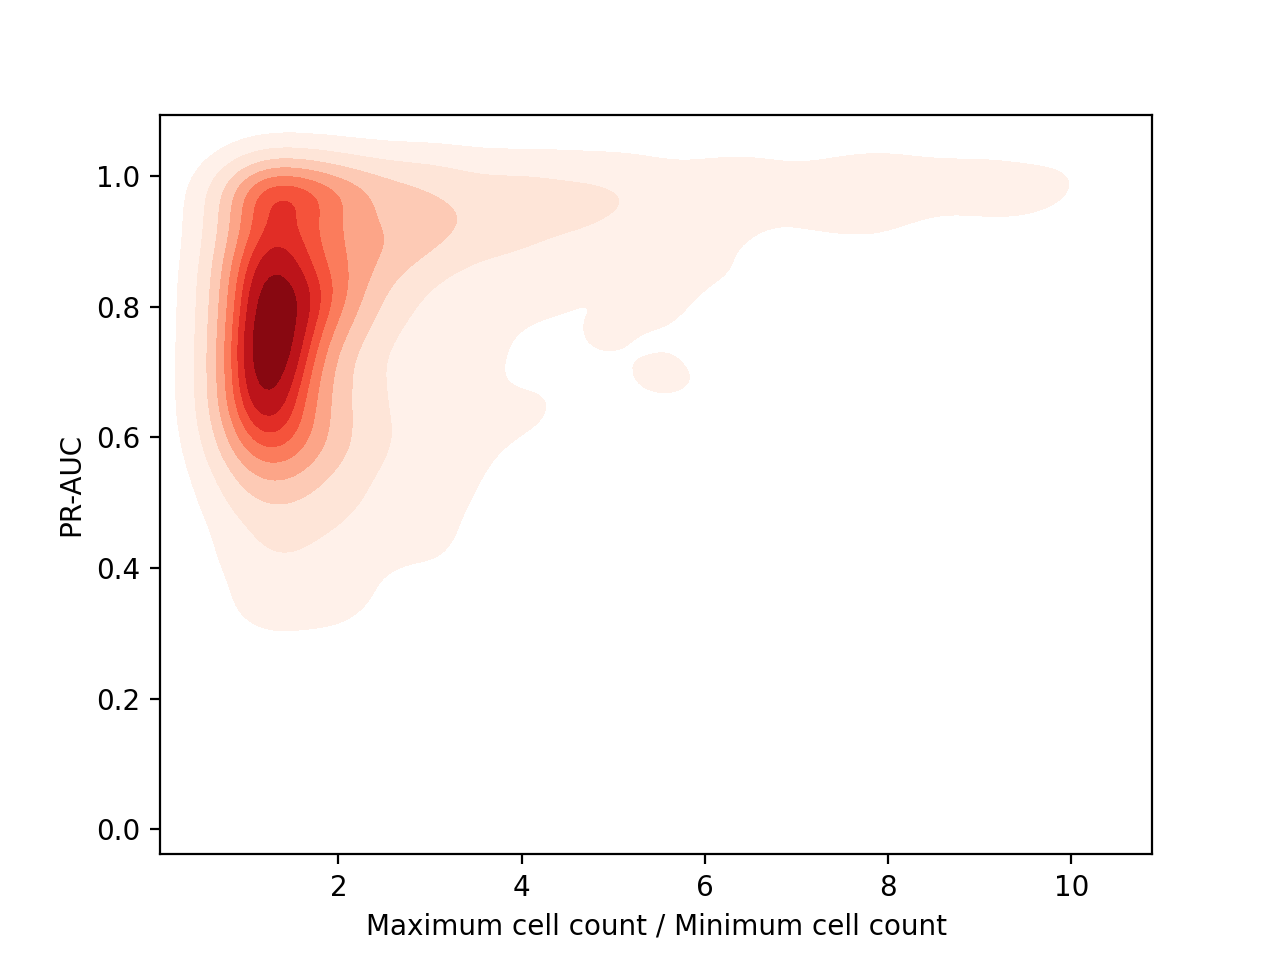

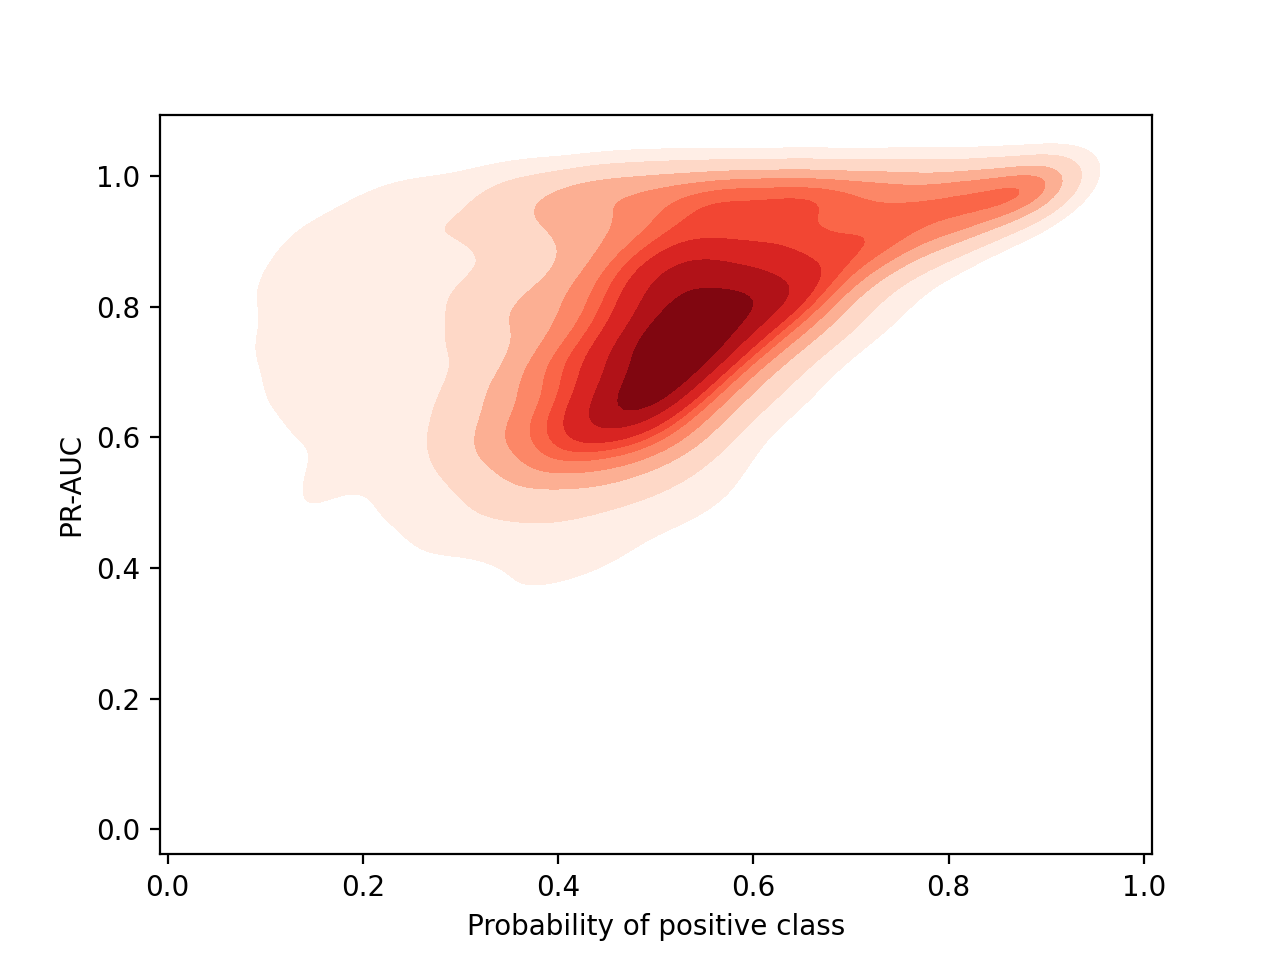

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(data = res_cc_filt.to_pandas(), x="Total_CC", y="PR_AUC", cmap="Reds", fill=True)
plt.xlabel('Total cell count')
plt.ylabel('PR-AUC')
plt.show()

sns.kdeplot(data = res_cc_filt.to_pandas(), x="Minimum_CC", y="PR_AUC", cmap="Reds", fill=True)
plt.xlabel('Minimum cell count')
plt.ylabel('PR-AUC')
plt.show()

sns.kdeplot(data = res_cc_filt.to_pandas(), x="FC_CC", y="PR_AUC", cmap="Reds", fill=True)
plt.xlabel('Maximum cell count / Minimum cell count')
plt.ylabel('PR-AUC')
plt.show()

sns.kdeplot(data = res_cc_filt.to_pandas(), x="prob_pos", y="PR_AUC", cmap="Reds", fill=True)
plt.xlabel('Probability of positive class')
plt.ylabel('PR-AUC')
plt.show()

In [19]:
print("Total cell count")
print(stats.pearsonr(
    res_cc_filt.drop_nulls().select("Total_CC").to_series(),
    res_cc_filt.drop_nulls().select("PR_AUC").to_series()
))
print(stats.spearmanr(
    res_cc_filt.drop_nulls().select("Total_CC").to_series(),
    res_cc_filt.drop_nulls().select("PR_AUC").to_series()
))

print("Minimum cell count")
print(stats.pearsonr(
    res_cc_filt.drop_nulls().select("Minimum_CC").to_series(),
    res_cc_filt.drop_nulls().select("PR_AUC").to_series()
))
print(stats.spearmanr(
    res_cc_filt.drop_nulls().select("Minimum_CC").to_series(),
    res_cc_filt.drop_nulls().select("PR_AUC").to_series()
))

print("FC cell count")
print(stats.pearsonr(
    res_cc_filt.drop_nulls().select("FC_CC").to_series(),
    res_cc_filt.drop_nulls().select("PR_AUC").to_series()
))
print(stats.spearmanr(
    res_cc_filt.drop_nulls().select("FC_CC").to_series(),
    res_cc_filt.drop_nulls().select("PR_AUC").to_series()
))

print("Probability of positive class")
print(stats.pearsonr(
    res_cc_filt.drop_nulls().select("prob_pos").to_series(),
    res_cc_filt.drop_nulls().select("PR_AUC").to_series()
))
print(stats.spearmanr(
    res_cc_filt.drop_nulls().select("prob_pos").to_series(),
    res_cc_filt.drop_nulls().select("PR_AUC").to_series()
))

Total cell count
PearsonRResult(statistic=0.05106170016021935, pvalue=2.261835805710535e-09)
SignificanceResult(statistic=0.048504794741138835, pvalue=1.3620537861134423e-08)
Minimum cell count
PearsonRResult(statistic=-0.02094948257574238, pvalue=0.014237126374018699)
SignificanceResult(statistic=-0.04816824381517137, pvalue=1.7138982709081002e-08)
FC cell count
PearsonRResult(statistic=0.15154065970139577, pvalue=3.963411481611995e-71)
SignificanceResult(statistic=0.2255623511217893, pvalue=1.865419908537461e-157)
Probability of positive class
PearsonRResult(statistic=0.4797758743775177, pvalue=0.0)
SignificanceResult(statistic=0.4901618253152386, pvalue=0.0)
